In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_DIR"] = "/opt/cuda"

In [3]:
# load, average and merge sensor samples
data_dir = 'sample_data/Bearing_Sensor_Data_pt1'
train = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    # train = train.append(dataset_mean_abs)
    train = pd.concat([train, dataset_mean_abs])
    
train.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']
#train.head()

In [4]:
# transform data file index to datetime and sort in chronological order
train.index = pd.to_datetime(train.index, format='%Y.%m.%d.%H.%M.%S')
train = train.sort_index()
train.to_csv('Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", train.shape)
train.head()

Dataset shape: (486, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


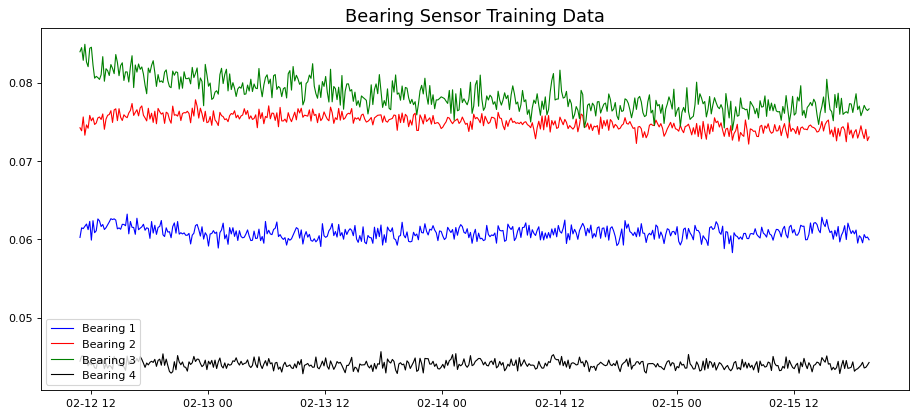

In [5]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

In [6]:
# transforming data from the time domain to the frequency domain using fast Fourier transform
train_fft = np.fft.fft(train)


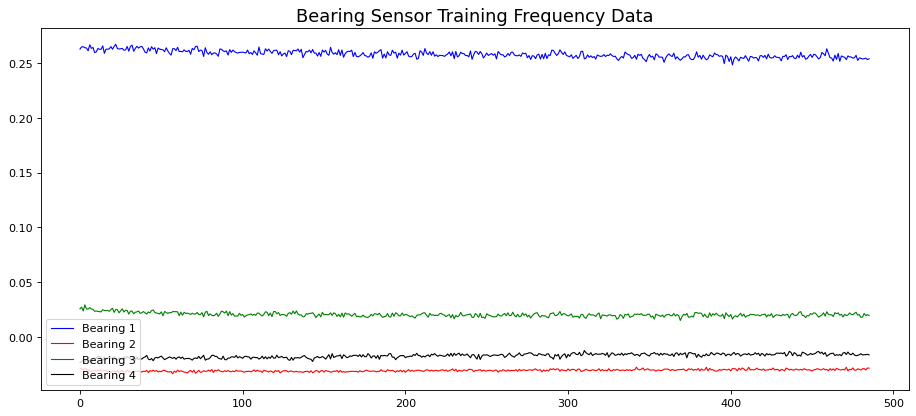

In [7]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(train_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Frequency Data', fontsize=16)
plt.show()

In [8]:
# normalize the data

from sklearn.preprocessing import MinMaxScaler
import joblib
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
# X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [9]:
X_train.shape

(486, 4)

In [10]:
def generate_sequence(data, sequence_length):
	seq_data = []
	# print(seq_data)
	for i in range(len(data)- sequence_length+1):
		seq = data[ i : i+sequence_length ]
		# print(seq)
		seq_data.append(seq)

	# print(seq_data)
	return np.array(seq_data)

In [11]:
SEQUENCE_LENGTH = 20
a = generate_sequence(X_train, SEQUENCE_LENGTH)

In [12]:
X_train.shape

(486, 4)

In [13]:
print(a.shape)

(467, 20, 4)


In [14]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import CuDNNLSTM, Input, Dense, RepeatVector, TimeDistributed

2023-03-04 11:40:44.138376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 11:40:44.933709: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-04 11:40:44.933783: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-04 11:40:44.933790: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [15]:
model = Sequential()
model.add(Input(shape=(a.shape[1], a.shape[2])))
model.add(CuDNNLSTM(64, return_sequences=True  ))
model.add(CuDNNLSTM(SEQUENCE_LENGTH, return_sequences=False ))
model.add(Dense(SEQUENCE_LENGTH))
model.add(RepeatVector(SEQUENCE_LENGTH))
model.add(CuDNNLSTM(SEQUENCE_LENGTH, return_sequences=True ))
model.add(CuDNNLSTM(64, return_sequences=True  ))
model.add(TimeDistributed(Dense(a.shape[2])))

2023-03-04 11:40:45.699137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 11:40:45.715334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 11:40:45.715538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 11:40:45.715913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [16]:
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm (CuDNNLSTM)      (None, 20, 64)            17920     
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 20)                6880      
                                                                 
 dense (Dense)               (None, 20)                420       
                                                                 
 repeat_vector (RepeatVector  (None, 20, 20)           0         
 )                                                               
                                                                 
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 20, 20)            3360      
                                                                 
 cu_dnnlstm_3 (CuDNNLSTM)    (None, 20, 64)            22016     
                                                        

In [17]:
history = model.fit(a, a, epochs=3, batch_size=1, validation_split=0.05, ).history

Epoch 1/3


2023-03-04 11:40:49.337925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-04 11:40:49.581905: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fea06e44f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-04 11:40:49.581927: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-03-04 11:40:49.585777: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-04 11:40:49.837726: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


443/443 [==============================] - 7s 5ms/step - loss: 0.1398 - val_loss: 0.1258
Epoch 2/3
443/443 [==============================] - 2s 4ms/step - loss: 0.1133 - val_loss: 0.1333
Epoch 3/3
443/443 [==============================] - 2s 4ms/step - loss: 0.1117 - val_loss: 0.1201


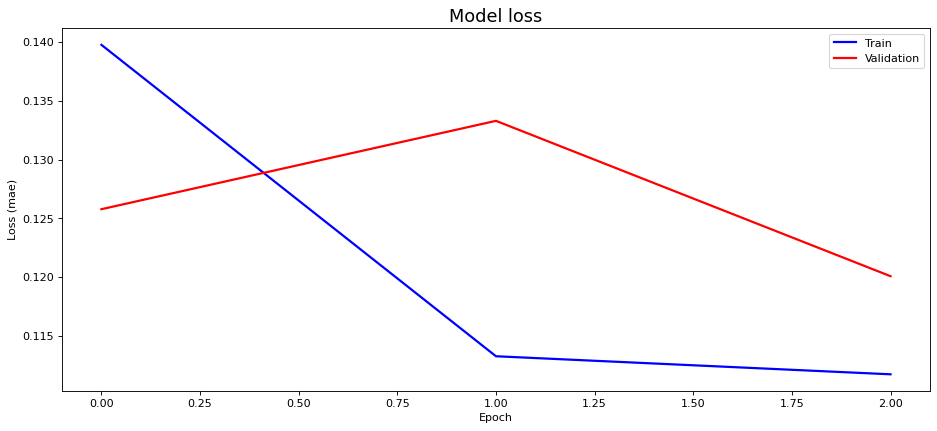

In [18]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [19]:
# load, average and merge sensor samples
data_dir = 'sample_data/Bearing_Sensor_Data_pt2'
test = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    # test = test.append(dataset_mean_abs)
    test = pd.concat([test, dataset_mean_abs])
    
test.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']
#train.head()

In [20]:
# transform data file index to datetime and sort in chronological order
test.index = pd.to_datetime(test.index, format='%Y.%m.%d.%H.%M.%S')
test = test.sort_index()
test.to_csv('Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", test.shape)
test.head()

Dataset shape: (496, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-15 19:52:39,0.061805,0.074442,0.077397,0.044164
2004-02-15 20:02:39,0.059113,0.073290,0.075332,0.043485
2004-02-15 20:12:39,0.059398,0.073231,0.075814,0.042777
2004-02-15 20:22:39,0.060979,0.073034,0.076009,0.044229
2004-02-15 20:32:39,0.061083,0.073050,0.076066,0.044466


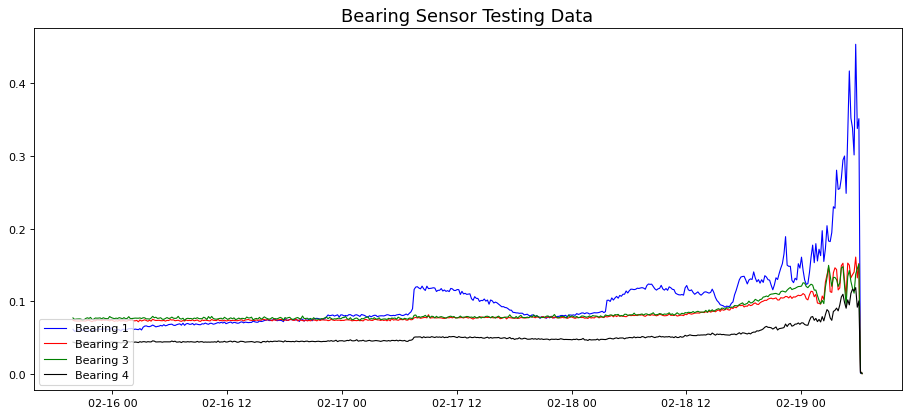

In [21]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Testing Data', fontsize=16)
plt.show()

In [22]:
test_fft = np.fft.fft(test)


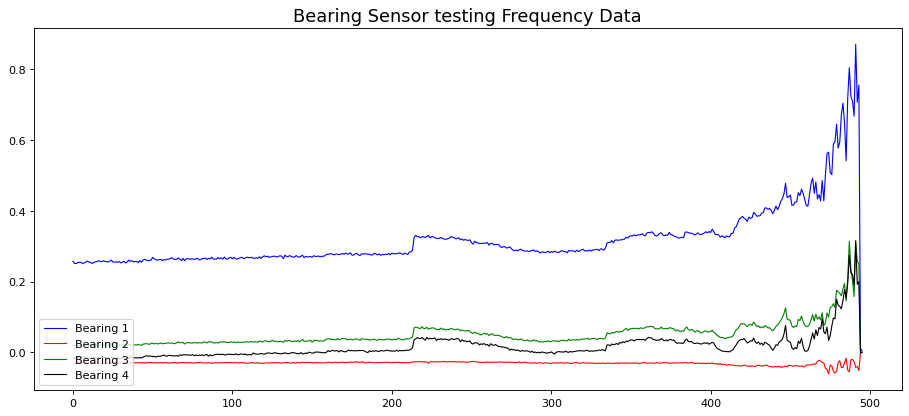

In [23]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(test_fft[:,0].real, label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(test_fft[:,1].imag, label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(test_fft[:,2].real, label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(test_fft[:,3].real, label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor testing Frequency Data', fontsize=16)
plt.show()

In [24]:
X_test = scaler.transform(test)

In [25]:
X_test.shape

(496, 4)

In [26]:
b = generate_sequence(X_test, SEQUENCE_LENGTH)

In [27]:
print(b.shape)

(477, 20, 4)


In [28]:
b_pred = model.predict(b)

15/15 [==============================] - 0s 4ms/step


In [29]:
b.shape

(477, 20, 4)

In [30]:
b_pred.shape

(477, 20, 4)

In [31]:
loss = np.mean(np.abs(b_pred-b), axis = 1)

In [32]:
loss.shape

(477, 4)

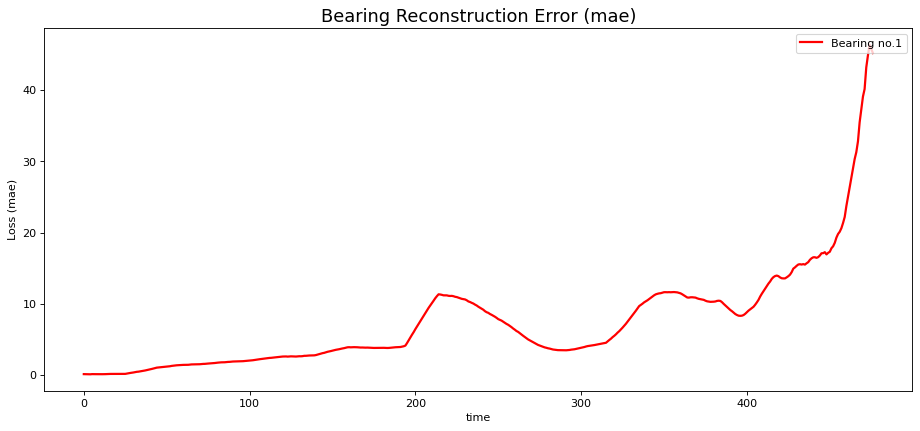

In [41]:
# natural numbering of the bearings
BEARINGNUMBER = 1
BEARINGNUMBER_WHOLE = BEARINGNUMBER - 1
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)

ax.plot(loss[:, BEARINGNUMBER_WHOLE], 'r', label=f'Bearing no.{BEARINGNUMBER}', linewidth=2)

ax.set_title('Bearing Reconstruction Error (mae)', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('time')
ax.legend(loc='upper right')
# plt.ylim(0, 1)
plt.show()

In [34]:
a_pred = model.predict(a)

15/15 [==============================] - 0s 4ms/step


In [35]:
loss_a = np.mean(np.abs(a_pred - a), axis = 1)

In [36]:
# loss_a[:, 1]

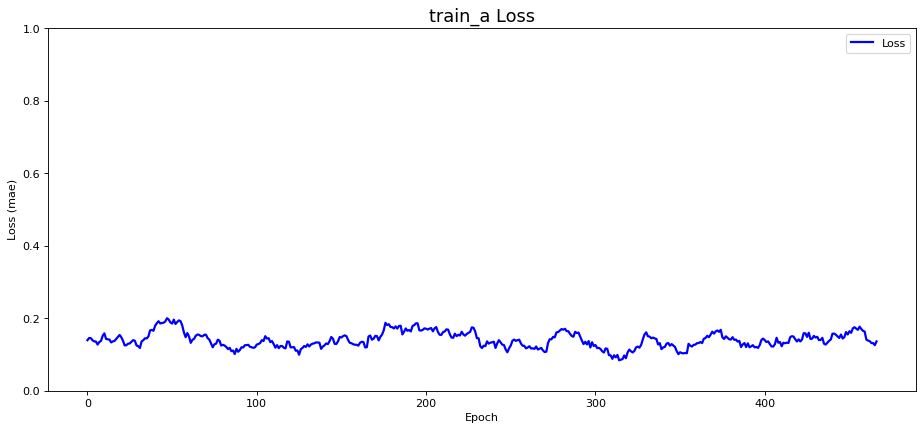

In [37]:
BEARINGNUMBER_TRAIN_A = 4

fig, ax = plt.subplots(figsize=(14, 6), dpi=80)

ax.plot(loss_a[:, BEARINGNUMBER_TRAIN_A-1], 'b', label='Loss', linewidth=2)

ax.set_title('train_a Loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.ylim(0, 1)
plt.show()